In [1]:
#Required python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import re

import nltk
import nltk.data
from string import punctuation 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [2]:
df_6emotions = pd.read_pickle('../data/raw/emotions_training.pkl')
df_senti=pd.read_csv("../data/raw/sentiments_training.csv", encoding= 'unicode_escape')

In [3]:
df_neutral=df_senti[df_senti.sentiment=='neutral'][['text','sentiment']]
df_neutral=df_neutral.rename(columns={'sentiment':'emotions'})
df_neutral

,text,emotions
0,"I`d have responded, if I were going",neutral
5,http://www.dothebouncy.com/smf - some shameles...,neutral
7,Soooo high,neutral
8,Both of you,neutral
10,"as much as i love to be hopeful, i reckon the...",neutral
...,...,...
27468,"few grilled mushrooms and olives, feta cheese ...",neutral
27469,94 more days till BH comes back to LA,neutral
27471,"i`m defying gravity. and nobody in alll of oz,...",neutral
27473,in spoke to you yesterday and u didnt respond...,neutral


In [4]:
df=pd.concat([df_6emotions,df_neutral], ignore_index=True)
df

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
427922,"few grilled mushrooms and olives, feta cheese ...",neutral
427923,94 more days till BH comes back to LA,neutral
427924,"i`m defying gravity. and nobody in alll of oz,...",neutral
427925,in spoke to you yesterday and u didnt respond...,neutral


In [5]:
def text_cleaning(text):
   
    text = re.sub(r"[^A-Za-z]", " ", str(text))
    
     #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.split()
    text = [w for w in text if not w in stopwords]
    text = " ".join(text)
        
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    text=text.lower()
    
    return text 

In [6]:
df['cleaned_text'] = df['text'].apply(lambda x: text_cleaning(x))


In [7]:
df.shape

(427927, 3)

In [8]:
df=df[df['cleaned_text'].map(len) > 0]
df.shape

(427871, 3)

In [9]:
df.to_csv("../data/processed/allemotions_raw_cleaned_data.csv", index=False, header=False)

In [10]:
#Defining class for each emotion
df['labels'] = df['emotions'].factorize()[0]
df.head()

/var/folders/th/qgn0zvb111n4qgsdq1z81tj00000gn/T/ipykernel_5740/866032133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['emotions'].factorize()[0]


,text,emotions,cleaned_text,labels
0,i feel awful about it too because it s my job ...,sadness,feel awful job get position succeed happen,0
1,im alone i feel awful,sadness,im alone feel awful,0
2,ive probably mentioned this before but i reall...,joy,ive probably mentioned really feel proud actua...,1
3,i was feeling a little low few days back,sadness,feeling little low day back,0
4,i beleive that i am much more sensitive to oth...,love,beleive much sensitive people feeling tend com...,2


In [11]:
uniquevalues = pd.unique(df[['emotions']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['emotion'])


In [12]:
df_unique

,emotion
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise
6,neutral


In [13]:
#importing libraries for models and nlp tasks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn import utils
from sklearn.utils.class_weight import compute_class_weight

In [14]:
tfidf_vectorizer = TfidfVectorizer()

In [15]:
y =df['labels']

In [16]:
#Train test split of the data
Xtrain, Xtest, ytrain, ytest = train_test_split(df['cleaned_text'], y, test_size=0.3,random_state=1,stratify=y)
Xtrain_tfidf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [43]:
pickle.dump(tfidf_vectorizer, open('../models/tfidf_vect_classweights.pkl', 'wb'))

##### Calculating class weights

In [35]:
weighting = compute_class_weight( class_weight ='balanced', classes =np.unique(y),y= y)
print(weighting)

[0.50439772 0.43330991 1.76895377 1.06653921 1.28119283 4.08258273
 5.51764114]


In [36]:
class_weights = dict(zip(np.unique(y), weighting))


##### Logistic Regression

In [38]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weights)
lr_mn.fit(Xtrain_tfidf, ytrain)


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5043977172658588, 1: 0.4333099059393507,
                                 2: 1.7689537700824383, 3: 1.0665392083793437,
                                 4: 1.2811928267502688, 5: 4.082582725850158,
                                 6: 5.5176411420318265},
                   multi_class='multinomial')

In [39]:
ypred_lr_mn=lr_mn.predict(Xtest_tfidf)

In [40]:
tr_acc_lr_mn = lr_mn.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

90.82798847446988 89.74930275315124


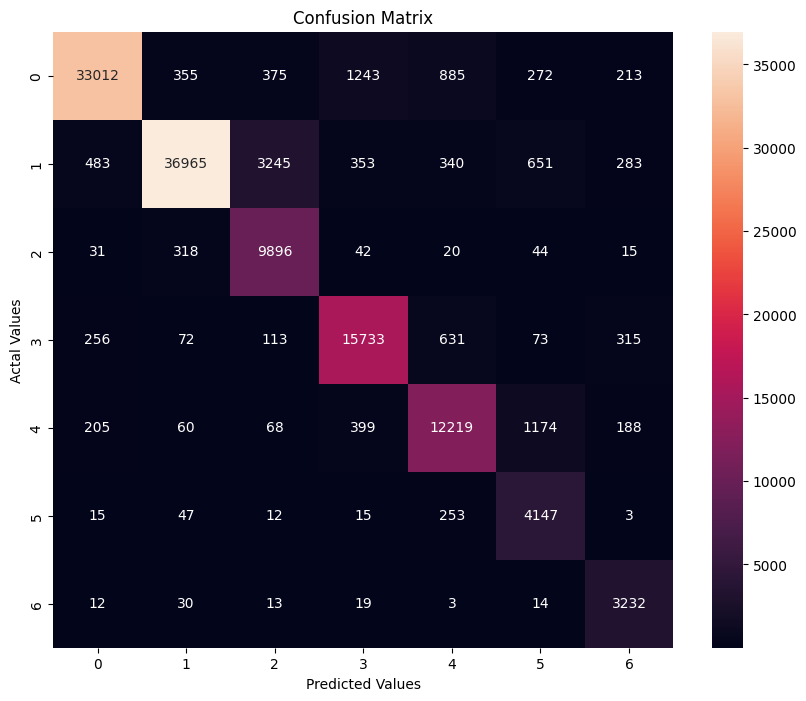

In [41]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [42]:
print(classification_report(ytest,ypred_lr_mn, digits=3))

              precision    recall  f1-score   support

           0      0.971     0.908     0.938     36355
           1      0.977     0.873     0.922     42320
           2      0.721     0.955     0.822     10366
           3      0.884     0.915     0.899     17193
           4      0.851     0.854     0.853     14313
           5      0.651     0.923     0.763      4492
           6      0.761     0.973     0.854      3323

    accuracy                          0.897    128362
   macro avg      0.831     0.914     0.864    128362
weighted avg      0.911     0.897     0.900    128362



In [44]:
pickle.dump(lr_mn, open('../models/lr_mn_classweights.pkl', 'wb'))